In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import math
import re
from collections import Counter
from plotting_functions import get_curve_idx_from_cluster_color, plot_specific_curves, \
                            plot_pca, plot_clusters_together, plot_clusters_seperately

# Load in all depth vs resistance curves into a dataframe list

In [21]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

In [22]:
data_features_df = pd.read_csv("data/features.csv")
non_clustering_features_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(non_clustering_features_list, axis=1)

# PCA Analysis

In [23]:
# size of figures produced
size_fig = (4,3)
def pca_analysis(clustering_features_df_list):
    pca = PCA(n_components=len(clustering_features_df_list.columns))
    pca.fit(clustering_features_df_list.values)

    # plot scree plot
    plt.figure(figsize=size_fig)
    plt.title("Scree Plot")
    plt.xlabel("PC Number")
    plt.ylabel("Eigenvalue")
    plt.xticks(range(1, pca.n_components_+1))
    plt.plot(range(1, pca.n_components_+1), pca.explained_variance_)
    plt.show()

    # principal component table
    principle_components_table = pd.DataFrame({
        "PC": range(1,pca.n_components_+1),
        "Eigenvalue": pca.explained_variance_,
        "Proportion": pca.explained_variance_ratio_
    })
    principle_components_table.set_index('PC', inplace=True)
    principle_components_table["Cumulative"] = principle_components_table["Proportion"].cumsum()
    print(principle_components_table)

    loadings = pca.components_.T
    pc_labels = [f'PC{i+1}' for i in range(loadings.shape[1])]
    loadings_df = pd.DataFrame(loadings, index=clustering_features_df_list.columns, columns=pc_labels)
    print('\n')
    print(loadings_df)

# K-Means Clustering Implementation w/ k-means++ initialization for centroids

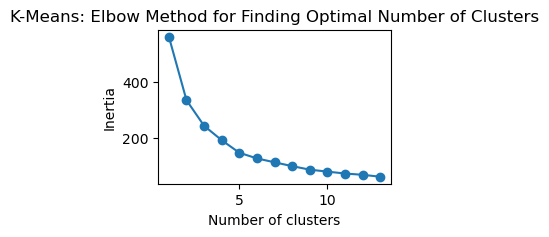

In [24]:
inertias = []
for k in range(1,14):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(clustering_features_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(3,2))
plt.plot(range(1,14), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

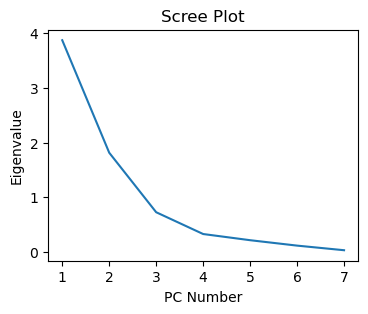

    Eigenvalue  Proportion  Cumulative
PC                                    
1     3.871505    0.546159    0.546159
2     1.813169    0.255786    0.801945
3     0.723959    0.102130    0.904075
4     0.325377    0.045901    0.949976
5     0.212310    0.029951    0.979927
6     0.113263    0.015978    0.995905
7     0.029025    0.004095    1.000000


                               PC1       PC2       PC3       PC4       PC5  \
overall_slope            -0.481679  0.183032 -0.047150  0.306434  0.122498   
max_depth                 0.484286 -0.082020  0.109266 -0.251518 -0.264406   
max_resistance           -0.445329  0.291402 -0.007045  0.249511 -0.263745   
num_peaks                 0.421298 -0.192023  0.108068  0.874110  0.077348   
largest_force_drop        0.261610  0.562749 -0.321552  0.112397 -0.620711   
curve_shape               0.087212  0.505580  0.843857 -0.039911  0.106548   
largest_force_drop_level  0.285652  0.515448 -0.398270 -0.047820  0.665511   

                      

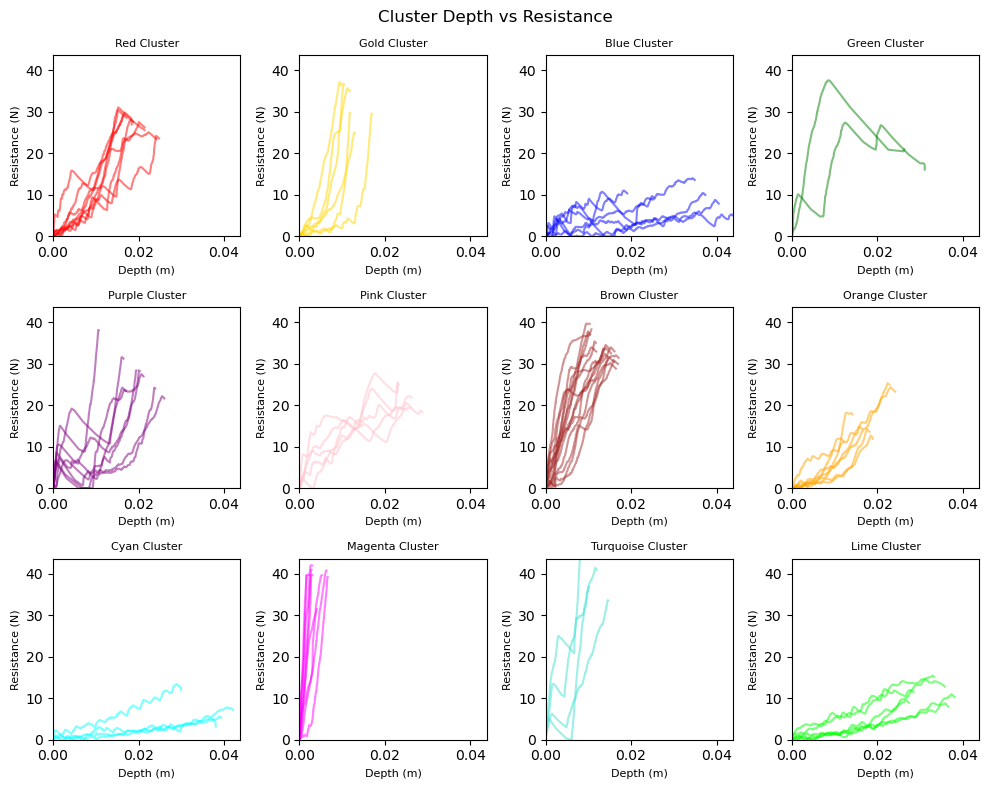

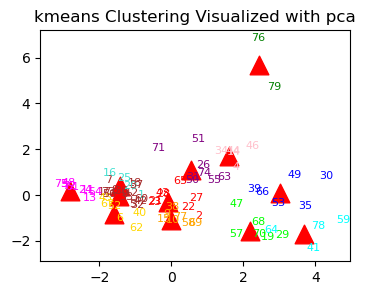

In [25]:
kmeans_elbow = 12
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(clustering_features_df)
# print(f"kmeans cluster centers: {kmeans.cluster_centers_}")
pca_analysis(clustering_features_df) # printing scree plot
# plot_clusters_together(kmeans.labels_, "kmeans")
plot_clusters_seperately(kmeans.labels_, clustering_features_df.index.tolist(), depth_resist_curve_df_list, "kmeans")
plot_pca(clustering_features_df, y_labels=kmeans.labels_, graph_title="kmeans", kmeans_centroids=kmeans.cluster_centers_)

# Hierarchical Clustering

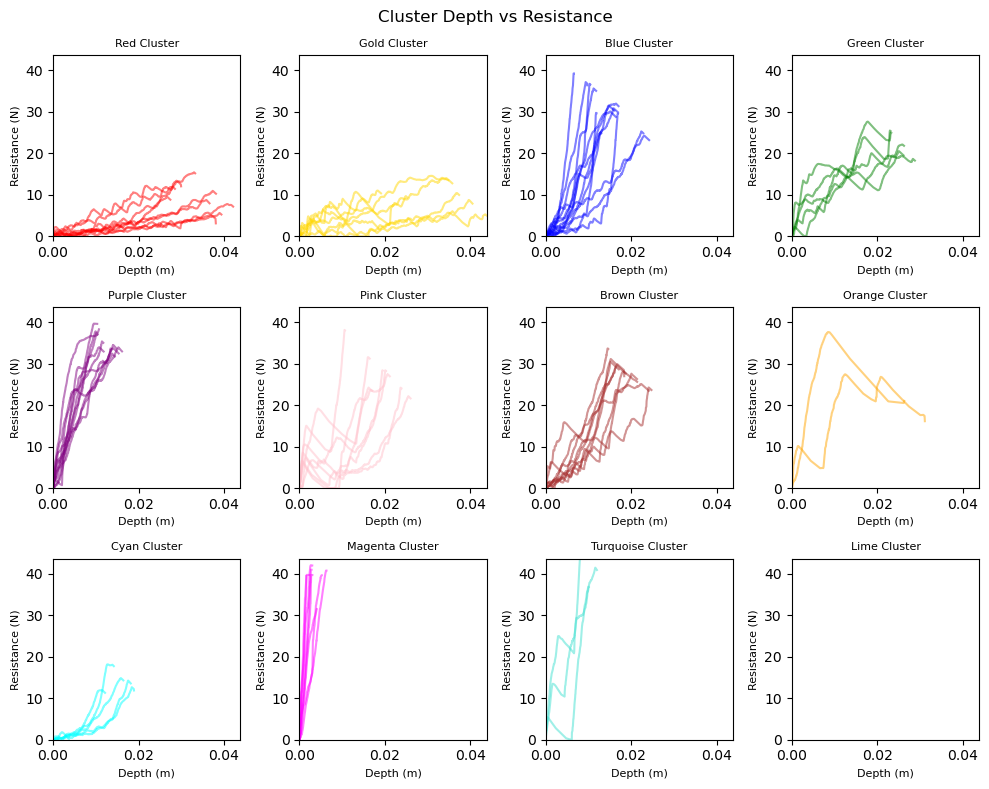

In [26]:

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=11)
hierarchical.fit(clustering_features_df)
linkage = "Ward"
plot_clusters_seperately(hierarchical.labels_, clustering_features_df.index.tolist(), depth_resist_curve_df_list)

# DBSCAN

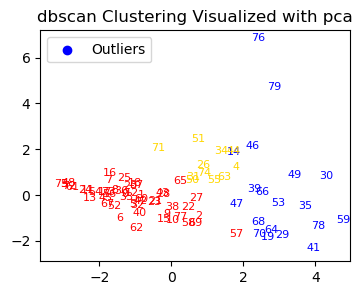

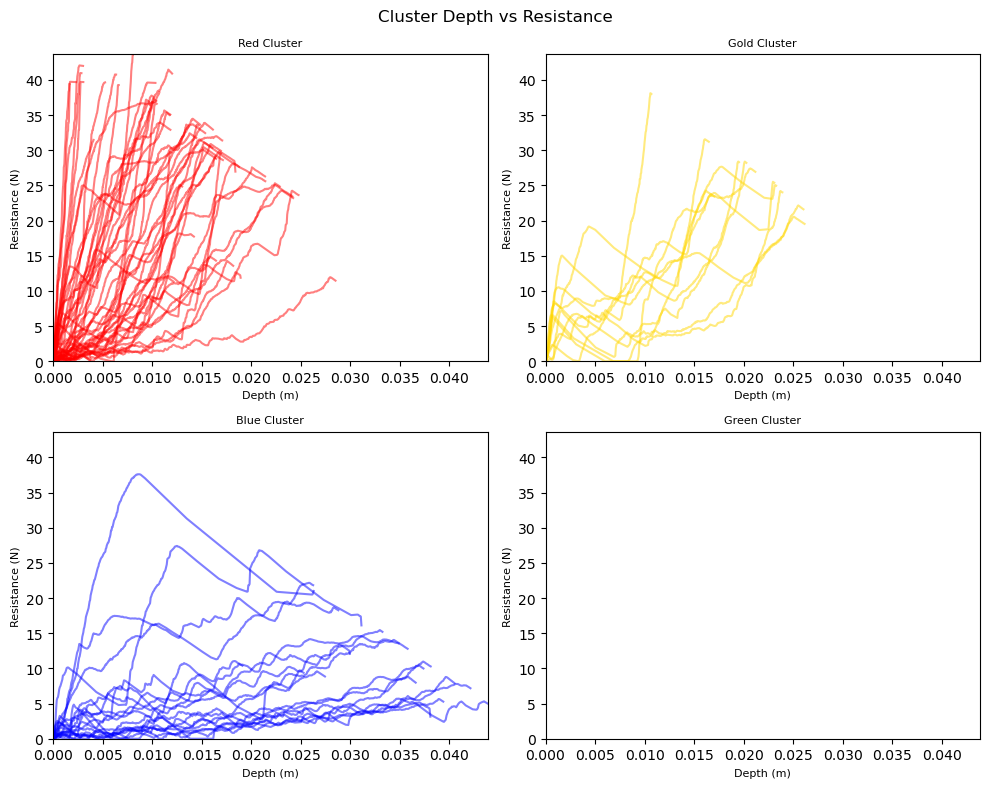

In [27]:

# eps=0.7, min_samples=3 works very well
dbscan = DBSCAN(eps=1.8, min_samples=10).fit(clustering_features_df)
cleaned_db_labels = [label if label != -1 else max(dbscan.labels_)+1 for label in dbscan.labels_]
# get_curve_idx_from_cluster_color("yellow", cleaned_db_labels)
plot_pca(clustering_features_df, cleaned_db_labels, 'dbscan')
plot_clusters_seperately(cleaned_db_labels, clustering_features_df.index.to_list(), depth_resist_curve_df_list)